In [6]:
import tensorflow as tf
import os
import cv2

In [3]:
# Avoid Out of Memory Error (OOM error)
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Removing Unfit Images using opencv2 and imghdr

In [7]:
import imghdr

In [11]:
data_dir = 'data'
image_extensions = ['jpeg', 'jpg', 'png', 'bmp']

In [17]:
# Going over all the images in the happy and sad directories and removing images with incompatible extensions
# Also logging out paths of images that cause issues when loading

for image_dir in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_dir)):
        image_path = os.path.join(data_dir, image_dir, image)
        try:
            img = cv2.imread(image_path)
            extension = imghdr.what(image_path)
            if extension not in image_extensions:
                os.remove(image_path);
        except Exception as e:
            print(f"Issue with image : {image_path}")

In [20]:
# Checking dataset size
happy_size = len(os.listdir(os.path.join(data_dir, 'happy-people-images')))
sad_size = len(os.listdir(os.path.join(data_dir, 'sad-people-images')))
print(happy_size, sad_size)

61 73


# Load Data

In [31]:
import numpy as np
import matplotlib.pyplot as plt

In [32]:
# tf.keras.utils.image_dataset_from_directory method does the following
# batches the dataset into size 32 sets batch_size=32 
# resizes the images to (256, 256)
# shuffles the images
# provides an option for validation split
# NOTE THAT IT RETURNS A GENERATOR

data = tf.keras.utils.image_dataset_from_directory('data')

Found 134 files belonging to 2 classes.


In [33]:
# Turning the generator into an iterator
# Iterator that functions as a generator for dynamically loading data (pipeline)
data_iterator = data.as_numpy_iterator()
data_iterator 

In [34]:
batch = data_iterator.next()
batch[0], batch[1]   # batch[0, 1] -> image, labels (0 for happy images, 1 for sad images)

(array([[[[  0.        ,   0.        ,   0.        ],
          [  0.        ,   0.        ,   0.        ],
          [  0.        ,   0.        ,   0.        ],
          ...,
          [  0.        ,   0.        ,   0.        ],
          [  0.        ,   0.        ,   0.        ],
          [  0.        ,   0.        ,   0.        ]],
 
         [[  0.        ,   0.        ,   0.        ],
          [  0.        ,   0.        ,   0.        ],
          [  0.        ,   0.        ,   0.        ],
          ...,
          [  0.        ,   0.        ,   0.        ],
          [  0.        ,   0.        ,   0.        ],
          [  0.        ,   0.        ,   0.        ]],
 
         [[  0.        ,   0.        ,   0.        ],
          [  0.        ,   0.        ,   0.        ],
          [  0.        ,   0.        ,   0.        ],
          ...,
          [  0.        ,   0.        ,   0.        ],
          [  0.        ,   0.        ,   0.        ],
          [  0.        ,   0.  

# Preprocessing

In [35]:
# 0-255 -> 0-1
data = data.map(lambda x, y: (x/255, y))

In [36]:
len(data)

5

In [39]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)
test_size = int(len(data)*0.1) + 1
train_size, val_size, test_size

(3, 1, 1)

In [45]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)
len(train), len(val), len(test)

(3, 1, 1)

# Building the Model

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [47]:
model = Sequential()

In [48]:
# input -> 16 Conv Neurons layer, 3*3 kernel, stride 1, relu activation, image resized by keras.utils to 256*256 with  3 color channels
model.add(Conv2D(16, (3,3), 1, activation = 'relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3, 3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3, 3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [50]:
model.compile('adam', loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])

In [51]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 14400)             0

In [52]:
log_dir = 'logs'

In [54]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)

In [55]:
hist = model.fit(train, epochs = 20, validation_data = val, callbacks=[tensorboard_callback])

Epoch 1/20
3/3 [==============================] - 9s 2s/step - loss: 1.3315 - accuracy: 0.5000 - val_loss: 0.9318 - val_accuracy: 0.2812
Epoch 2/20
3/3 [==============================] - 5s 2s/step - loss: 0.7465 - accuracy: 0.4792 - val_loss: 0.6755 - val_accuracy: 0.4375
Epoch 3/20
3/3 [==============================] - 6s 2s/step - loss: 0.6786 - accuracy: 0.4375 - val_loss: 0.6637 - val_accuracy: 0.6875
Epoch 4/20
3/3 [==============================] - 6s 2s/step - loss: 0.6348 - accuracy: 0.7188 - val_loss: 0.5778 - val_accuracy: 0.8125
Epoch 5/20
3/3 [==============================] - 6s 2s/step - loss: 0.5738 - accuracy: 0.7500 - val_loss: 0.4207 - val_accuracy: 0.8750
Epoch 6/20
3/3 [==============================] - 6s 2s/step - loss: 0.4919 - accuracy: 0.7396 - val_loss: 0.6121 - val_accuracy: 0.5625
Epoch 7/20
3/3 [==============================] - 7s 2s/step - loss: 0.4839 - accuracy: 0.7396 - val_loss: 0.5352 - val_accuracy: 0.7500
Epoch 8/20
3/3 [=========================

# Plot Performance

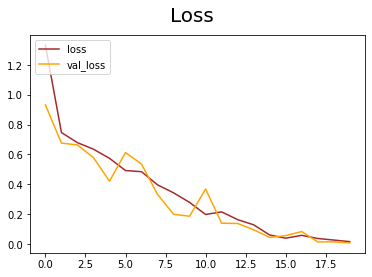

In [60]:
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'brown', label = 'loss')
plt.plot(hist.history['val_loss'], color = 'orange', label = 'val_loss')
fig.suptitle('Loss', fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()

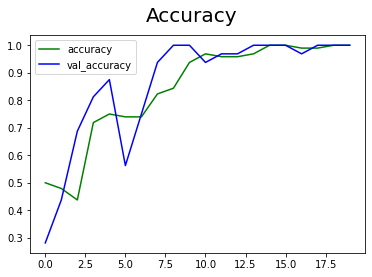

In [62]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color = 'green', label = 'accuracy')
plt.plot(hist.history['val_accuracy'], color = 'blue', label = 'val_accuracy')
fig.suptitle('Accuracy', fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()

# Evaluate Performance

In [63]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [64]:
precision = Precision()
recall = Recall()
bin_accuracy = BinaryAccuracy()

In [65]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    precision.update_state(y, yhat) # true value, predicted value
    recall.update_state(y, yhat)
    bin_accuracy.update_state(y, yhat)

In [67]:
print(f"Precision Result : {precision.result().numpy()}")
print(f"Recall Result : {recall.result().numpy()}")
print(f"Binary Result : {bin_accuracy.result().numpy()}")

Precision Result : 1.0
Recall Result : 1.0
Binary Result : 1.0


# Testing the model with unseen images

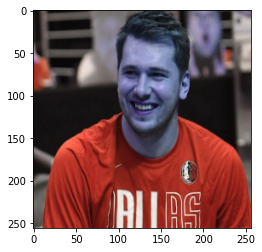

In [87]:
img_happy = cv2.imread('happy-test.jpeg')
resized_happy = tf.image.resize(img_happy, (256, 256))
plt.imshow(resized_happy.numpy().astype(int))

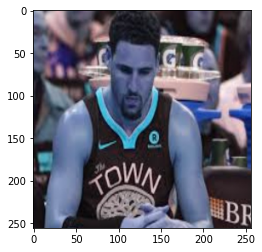

In [88]:
img_sad = cv2.imread('sad-test.jpeg')
resized_sad = tf.image.resize(img_sad,(256, 256))
plt.imshow(resized_sad.numpy().astype(int))

In [91]:
yhat_1 = model.predict(np.expand_dims(resized_happy/255, 0))
prediction_1 = "happy" if yhat_1 < 0.5 else "sad"


yhat_2 = model.predict(np.expand_dims(resized_sad/255, 0))
prediction_2 = "happy" if yhat_2 < 0.5 else "sad"

print(yhat_1)
print(yhat_2)

print(f"Prediction - 1: {prediction_1}")
print(f"Prediction - 2: {prediction_2}")

[[0.3592828]]
[[0.99806803]]
Prediction - 1: happy
Prediction - 2: sad


# Saving the model

In [92]:
from tensorflow.keras.models import load_model

In [93]:
model.save(os.path.join('models', 'Image-Classifier-Model.h5'))

In [96]:
# Loading the saved model back again
new_model = load_model(os.path.join('models', 'Image-Classifier-Model.h5'))

In [97]:
yhat = new_model.predict(np.expand_dims(resized_sad/255, 0))
print("happy" if yhat < 0.5 else "sad")

sad


In [98]:
yhat = new_model.predict(np.expand_dims(resized_happy/255, 0))
print("happy" if yhat < 0.5 else "sad")

happy
